In [1]:
# train_anemia_xgb.py
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
csv_path = "ol_removed.csv"  # change if your file is elsewhere

In [3]:
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at path: {csv_path}")

In [4]:
df = pd.read_csv(csv_path)

# Basic checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values per column:\n", df.isnull().sum())

Shape: (10505, 7)
Columns: ['Unnamed: 0', 'Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV', 'Result']
Missing values per column:
 Unnamed: 0    0
Gender        0
Hemoglobin    0
MCH           0
MCHC          0
MCV           0
Result        0
dtype: int64


In [5]:
# --- Preprocessing ---
# 1) Drop fully empty rows (if any)
df = df.dropna(how='all').reset_index(drop=True)

# 2) If there are non-numeric columns that shouldn't be, attempt conversion
for col in df.columns:
    if df[col].dtype == object:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 3) Fill numeric missing with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if df[c].isnull().any():
        df[c].fillna(df[c].median(), inplace=True)

In [6]:
# 4) Remove exact duplicates
before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
print(f"Removed {before - len(df)} duplicate rows.")

# 5) Ensure target column name (assumes 'Result' exists). Adjust if different.
target_col = "Result"
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Columns: {df.columns.tolist()}")

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

print("Class distribution:\n", y.value_counts())

Removed 0 duplicate rows.
Class distribution:
 Result
0    6522
1    3983
Name: count, dtype: int64


In [7]:
# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [8]:
apply_smote = False
try:
    from imblearn.over_sampling import SMOTE
    minor_ratio = y_train.value_counts(normalize=True).min()
    if minor_ratio < 0.40 and len(y_train) >= 10:
        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
        apply_smote = True
        print("Applied SMOTE. New training distribution:", np.bincount(y_train_res)/len(y_train_res))
    else:
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
except Exception as e:
    print("imblearn not available or failed; proceeding without SMOTE:", e)
    X_train_res, y_train_res = X_train.copy(), y_train.copy()

Applied SMOTE. New training distribution: [0.5 0.5]


In [9]:
# --- Model + hyperparameter search ---
use_xgb = True
try:
    from xgboost import XGBClassifier
    base_clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
except Exception:
    use_xgb = False
    from sklearn.ensemble import RandomForestClassifier
    base_clf = RandomForestClassifier(random_state=42)
    print("XGBoost not available; falling back to RandomForest.")

# Pipeline with scaling (helps some datasets)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", base_clf)
])

In [10]:
# Param distributions (for RandomizedSearchCV)
if use_xgb:
    param_dist = {
        "clf__n_estimators": [50, 100, 150, 200, 300],
        "clf__max_depth": [2, 3, 4, 5, 6, 8],
        "clf__learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
        "clf__subsample": [0.6, 0.8, 1.0],
        "clf__colsample_bytree": [0.5, 0.7, 1.0],
        "clf__gamma": [0, 0.1, 0.3, 1]
    }
else:
    param_dist = {
        "clf__n_estimators": [50, 100, 200, 300],
        "clf__max_depth": [None, 4, 6, 8],
        "clf__min_samples_leaf": [1, 2, 4]
    }

In [11]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rnd = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=30, cv=cv,
                         scoring="accuracy", n_jobs=-1, random_state=42, verbose=1)

rnd.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'clf__colsample_bytree': [0.5, 0.7, ...], 'clf__gamma': [0, 0.1, ...], 'clf__learning_rate': [0.01, 0.03, ...], 'clf__max_depth': [2, 3, ...], ...}"
,n_iter,30
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [12]:
best = rnd.best_estimator_
print("Best params:", rnd.best_params_)

Best params: {'clf__subsample': 1.0, 'clf__n_estimators': 100, 'clf__max_depth': 5, 'clf__learning_rate': 0.2, 'clf__gamma': 0.1, 'clf__colsample_bytree': 0.5}


In [ ]:
# Evaluate

y_pred = best.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("Classification report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 0.9986
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1304
           1       1.00      1.00      1.00       797

    accuracy                           1.00      2101
   macro avg       1.00      1.00      1.00      2101
weighted avg       1.00      1.00      1.00      2101

Confusion matrix:
 [[1304    0]
 [   3  794]]


In [21]:
X_test.head()

,Unnamed: 0,Gender,Hemoglobin,MCH,MCHC,MCV
8486,11811,0,12.4,29.0,35.0,82.8
7748,11047,1,14.3,29.8,32.1,92.7
3193,6347,0,15.2,27.0,32.8,82.1
7549,10840,1,13.9,31.0,33.1,93.7
3537,6701,0,16.3,29.9,34.2,87.6


Feature importances:
 f0    457.0
f2    324.0
f4    324.0
f3    323.0
f5    288.0
f1     52.0
dtype: float64


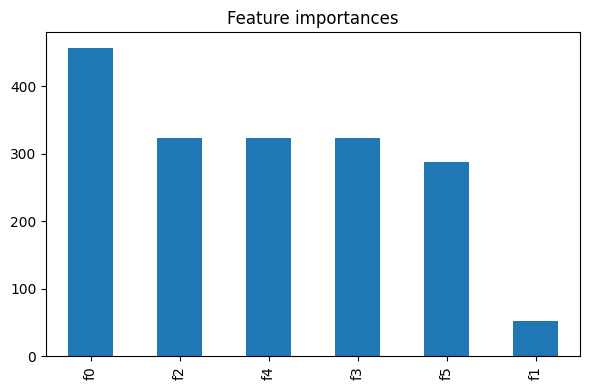

Saved trained model to best_anemia_model.pkl


In [14]:
# Feature importance (if available)
try:
    if use_xgb:
        booster = best.named_steps['clf'].get_booster()
        fmap = booster.get_score(importance_type='weight')
        # map names to scores
        fi_series = pd.Series(fmap).sort_values(ascending=False)
    else:
        fi = best.named_steps['clf'].feature_importances_
        fi_series = pd.Series(fi, index=X.columns).sort_values(ascending=False)
    print("Feature importances:\n", fi_series)
    # plot
    plt.figure(figsize=(6,4))
    fi_series.plot(kind='bar')
    plt.title("Feature importances")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not compute feature importances:", e)

# Save model
out_path = "best_anemia_model.pkl"
with open(out_path, "wb") as f:
    pickle.dump(best, f)
print(f"Saved trained model to {out_path}")

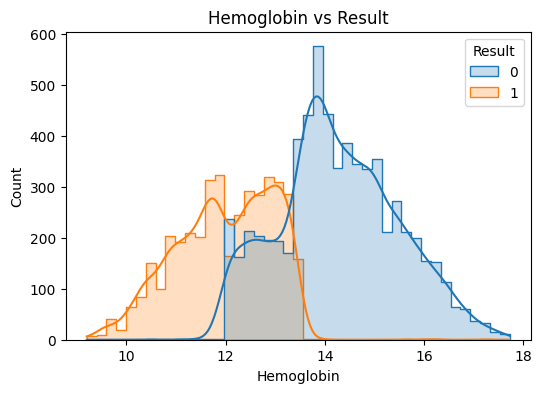

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.histplot(data=df, x="Hemoglobin", hue="Result", kde=True, element="step")
plt.title("Hemoglobin vs Result")
plt.show()


In [16]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best.named_steps['clf'], X, y, cv=5, scoring="accuracy")
print("Cross-validated accuracy:", scores, "Mean:", scores.mean())


Cross-validated accuracy: [0.87291766 0.96335079 1.         1.         0.99857211] Mean: 0.9669681104236079


In [20]:
X_test.head()

,Unnamed: 0,Gender,Hemoglobin,MCH,MCHC,MCV
8486,11811,0,12.4,29.0,35.0,82.8
7748,11047,1,14.3,29.8,32.1,92.7
3193,6347,0,15.2,27.0,32.8,82.1
7549,10840,1,13.9,31.0,33.1,93.7
3537,6701,0,16.3,29.9,34.2,87.6
